# Trigger Revision for 2025/2026 Cyclone Season

In [2]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [78]:
from pathlib import Path
import pandas as pd
import ocha_stratus as stratus
import matplotlib.pyplot as plt
import geopandas as gpd
import math
from datetime import datetime, timedelta
from src.datasources import codab, rsmc, imerg, helpers
from src import db_utils
from src.constants import *
from src.utils import *

In [7]:
adm1 = stratus.codab.load_codab_from_fieldmaps(iso3, admin_level=1)

In [47]:
load_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "processed"
    / "moz"
    / "landfall_time_location_fixed_adm1_v7.csv"
)
landfall_df = pd.read_csv(load_path)
date_cols = ["year", "month", "day"]
landfall_df[date_cols] = landfall_df[date_cols].astype(int)
landfall_df["landfall_date"] = pd.to_datetime(
    landfall_df[["year", "month", "day"]]
)
landfall_df.head()

,ISO_TIME,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,NATURE,LAT,LON,...,day,hour,min,geometry,date,ADM0_PT,actual_within_land,point_location,0,landfall_date
0,03/01/2000 05:00,1999357S08076,2000,103,SI,MM,ASTRIDE,TS,-13.633333,40.466667,...,3,5.0,0,POINT (40.46666666666666 -13.633333333333333),03/01/2000,Moçambique,True,Landfall,NaN,2000-01-03
1,22/02/2000 07:30,2000032S11116,2000,9,SI,MM,ELINE:LEONE,TS,-20.550000,34.750000,...,22,7.5,0,POINT (34.75 -20.55),22/02/2000,Moçambique,True,Landfall,NaN,2000-02-22
2,09/03/2000 00:30,2000058S14063,2000,14,SI,MM,GLORIA,TS,-23.983333,35.433333,...,9,0.5,0,POINT (35.43333333333334 -23.983333333333334),09/03/2000,Moçambique,True,Landfall,NaN,2000-03-09
3,08/04/2000 06:00,2000083S17102,2000,20,SI,MM,HUDAH,TS,-17.200000,38.300000,...,8,6.0,0,POINT (38.3 -17.2),08/04/2000,Moçambique,True,Landfall,NaN,2000-04-08
4,31/12/2002 21:30,2002364S16045,2003,99,SI,MM,DELFINA,TS,-15.983333,40.066667,...,26,17.5,0,POINT (40.06666666666667 -15.983333333333334),31/12/2002,Moçambique,True,Landfall,NaN,2002-10-26


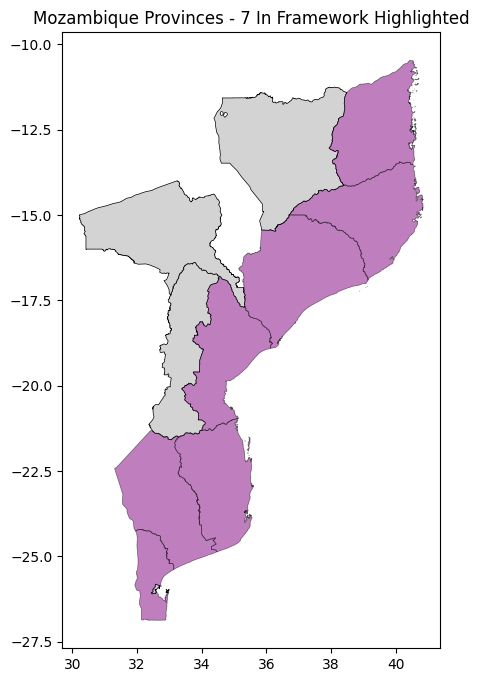

In [16]:
adm1["in_framework"] = adm1["adm1_name"].isin(ADMS)
fig, ax = plt.subplots(figsize=(10, 8))
adm1[adm1["in_framework"] == False].plot(
    ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5
)
adm1[adm1["in_framework"] == True].plot(
    ax=ax, color="purple", edgecolor="black", linewidth=0.5, alpha=0.5
)
ax.set_title("Mozambique Provinces - 7 In Framework Highlighted")
plt.show()

In [ ]:
# to add the return period based on the revisions
# 7 provinces in the framework
# threshold of 118km/h (64 knots) for wind speed
# threshold of 120mm for rainfall over 3 days

#df_rsmc = rsmc.load_historical_forecast_distances()
#distance_cols = [x for x in df_rsmc.columns if "_distance_km" in x]
#df_rsmc["any_distance_km"] = df_rsmc[distance_cols].min(axis=1)

In [30]:
# intersecting df_rsmc with adm1 to get only the relevant provinces
df_rsmc = rsmc.load_processed_historical_forecasts()
# turn latitude and longitude into a geodataframe
df_rsmc = gpd.GeoDataFrame(
    df_rsmc,
    geometry=gpd.points_from_xy(df_rsmc["longitude"], df_rsmc["latitude"]),
    crs="OGC:CRS84",
)
df_rsmc_adm1 = gpd.sjoin(
    df_rsmc,
    adm1[adm1["in_framework"] == True],
    how="inner",
    predicate="within",
)
df_rsmc_adm1.head(5)

,cyclone_name,cyclone_number,basin,lt_hour,valid_time,latitude,longitude,min_presssure_hpa,last_isobar_pres_hpa,last_isobar_rad_nm,...,region2_nm,region1_cd,region1_nm,status_cd,status_nm,wld_date,wld_update,wld_view,wld_notes,in_framework
70,FREDDY,7,SWI,36,2023-03-11 18:00:00+00:00,-17.52,37.02,NaN,NaN,NaN,...,Sub-Saharan Africa,2,Africa,1,State,2025-02-24,2025-07-29,intl,None,True
71,FREDDY,7,SWI,48,2023-03-12 06:00:00+00:00,-17.34,36.58,NaN,NaN,NaN,...,Sub-Saharan Africa,2,Africa,1,State,2025-02-24,2025-07-29,intl,None,True
72,FREDDY,7,SWI,60,2023-03-12 18:00:00+00:00,-17.07,36.13,NaN,NaN,NaN,...,Sub-Saharan Africa,2,Africa,1,State,2025-02-24,2025-07-29,intl,None,True
73,FREDDY,7,SWI,72,2023-03-13 06:00:00+00:00,-16.80,35.48,NaN,NaN,NaN,...,Sub-Saharan Africa,2,Africa,1,State,2025-02-24,2025-07-29,intl,None,True
129,0620182019,6,SWI,84,2019-01-22 18:00:00+00:00,-18.56,35.08,NaN,NaN,NaN,...,Sub-Saharan Africa,2,Africa,1,State,2025-02-24,2025-07-29,intl,None,True


In [33]:
df_rsmc_adm1.columns

Index(['cyclone_name', 'cyclone_number', 'basin', 'lt_hour', 'valid_time',
       'latitude', 'longitude', 'min_presssure_hpa', 'last_isobar_pres_hpa',
       'last_isobar_rad_nm', 'max_wind_kt', 'max_wind_gusts_kt',
       'max_wind_radius_nm', 'nwq_27kt_nm', 'neq_27kt_nm', 'seq_27kt_nm',
       'swq_27kt_nm', 'nwq_34kt_nm', 'neq_34kt_nm', 'seq_34kt_nm',
       'swq_34kt_nm', 'nwq_50kt_nm', 'neq_50kt_nm', 'seq_50kt_nm',
       'swq_50kt_nm', 'issue_time', 'season', 'nwq_64kt_nm', 'neq_64kt_nm',
       'seq_64kt_nm', 'swq_64kt_nm', 'numberseason', 'geometry', 'index_right',
       'fid', 'adm1_id', 'adm1_src', 'adm1_name', 'adm1_name1', 'adm1_name2',
       'adm0_id', 'adm0_src', 'adm0_name', 'adm0_name1', 'adm0_name2',
       'src_lvl', 'src_lang', 'src_lang1', 'src_lang2', 'src_date',
       'src_update', 'src_name', 'src_name1', 'src_lic', 'src_url', 'src_grp',
       'iso_cd', 'iso_2', 'iso_3', 'iso_3_grp', 'region3_cd', 'region3_nm',
       'region2_cd', 'region2_nm', 'region1_cd'

In [53]:
IMERG_START_DATE = pd.to_datetime("2000-06-01")
extra_days = 1
aoi_adm1_pcodes = adm1[adm1["in_framework"]]["adm1_src"].unique()
dfs = []
for sid, row in landfall_df.set_index("SID").iterrows():
    landfall_date = row["landfall_date"]
    start_date = landfall_date - pd.Timedelta(days=extra_days)
    end_date = landfall_date + pd.Timedelta(days=extra_days)
    if end_date < IMERG_START_DATE:
        print(f"{row['NAME']} too early")
        continue
    df_in = imerg.fetch_imerg_data(aoi_adm1_pcodes, start_date, end_date)
    df_in["SID"] = sid
    df_in["NAME"] = row["NAME"]
    dfs.append(df_in)
imerg_df = pd.concat(dfs, ignore_index=True)
imerg_sum_df = (
    imerg_df.groupby(["pcode", "SID", "NAME"])["mean"].sum().reset_index()
)
imerg_sum_df = imerg_sum_df.rename(columns={"mean": "sum_mean_rain"})
imerg_sum_df.head()

ASTRIDE too early
ELINE:LEONE too early
GLORIA too early
HUDAH too early


,pcode,SID,NAME,sum_mean_rain
0,MZ01,2002364S16045,DELFINA,0.016015
1,MZ01,2003056S21042,JAPHET,0.171965
2,MZ01,2007043S11071,FAVIO,12.483385
3,MZ01,2008062S10064,JOKWE,47.419393
4,MZ01,2009082S16039,IZILDA,16.721129


### Return Period

In [ ]:
ibtracs_path = adm1_path = (
    Path(AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
)
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
gdf_points = gpd.read_file(points_path)


In [99]:
def calculate_storm_return_period(
    df, wind_speed_kmh, start_year, num_storms_year
):
    """
    Calculates the return period for cyclones based on wind speed threshold.

    Args:
    df: DataFrame containing the cyclone data.
    wind_speed_kmh: Wind speed threshold in km/h.
    start_year: The year to start the calculation from.
    num_storms_year: Number of storms to predict per year.

    Returns:
    None (Prints the return period and probability).
    """
    # Conversion factor from kilometers per hour to knots
    kmh_to_knots = 1 / KPH2KNOTS

    # Convert the given speed from km/h to knots
    speed_knots = wind_speed_kmh * kmh_to_knots

    # Extract the year from the 'ISO_TIME' column
    df["year"] = df["ISO_TIME"].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
    )

    # Filter the DataFrame for records from the start year and with wind speed above the threshold
    df_filtered = df[
        (df["year"] >= start_year) & (df["REU_USA_WIND"] >= speed_knots)
    ]

    # Count unique storms
    unique_storms = df_filtered["NAME"].nunique()

    # Calculate the total number of years in the filtered DataFrame
    yr_len = 2024 - start_year + 1

    # Calculate the combined return period
    combined_return_period = yr_len / unique_storms

    print(
        f"The combined return period of storms over {wind_speed_kmh}km/h is 1-in-{round(combined_return_period, 1)} years."
    )

    # http://hurricanepredictor.com/Methodology/USmethodology.pdf
    # Trying out the methodology above
    # using Poisson distribution
    ave_num = unique_storms / yr_len
    expected_probability = (
        math.exp(-ave_num)
        * (ave_num**num_storms_year)
        / math.factorial(num_storms_year)
    )
    print(
        f"Probability of {num_storms_year} or more storms occurring in any given year is {expected_probability:.4f}."
    )

In [100]:
gdf_points.to_crs("OGC:CRS84", inplace=True)
gdf_points_adm1 = gpd.sjoin(
    gdf_points, adm1, how="inner", predicate="intersects"
)
gdf_points_adm1["REU_USA_WIND"] = gdf_points_adm1["REU_WIND"].fillna(
    gdf_points_adm1["USA_WIND"] * MIN1_TO_MIN10
)
calculate_storm_return_period(gdf_points_adm1, THRESHOLD_SPEED_OPT2, 1980, 1)

The combined return period of storms over 118km/h is 1-in-3.0 years.
Probability of 1 or more storms occurring in any given year is 0.2388.


### Historical Validation

In [ ]:
readiness_max_lt = 120
readiness_min_lt = 72
action_max_lt = 72
action_min_lt = 6
wind_speed_trigger_kmh = 118  # km/h
rainfall_trigger_mm = 120  # mm over 3 days, testing with 175mm
wind_speed_trigger_kts = 64  # knots

In [67]:
# getting last 8 digits to get seasons from column "numberseason"

num_seasons = (df_rsmc["numberseason"].astype(str).str[-8:]).nunique()
num_seasons

14

In [81]:
# checking the number of storms that would have triggered readiness
readiness_storms = df_rsmc_adm1[
    df_rsmc_adm1["lt_hour"].between(
        readiness_min_lt, readiness_max_lt, inclusive="both"
    )
    & (df_rsmc_adm1["max_wind_kt"] >= wind_speed_trigger_kts)
]["cyclone_name"].unique()
readiness_storms

array(['IDAI', 'IRINA', 'GOMBE', '1420182019', 'ELOISE', 'FREDDY',
       'KENNETH'], dtype=object)

In [82]:
# checking the number of storms that would have triggered action
action_storms = df_rsmc_adm1[
    df_rsmc_adm1["lt_hour"].between(
        action_min_lt, action_max_lt, inclusive="both"
    )
    & (df_rsmc_adm1["max_wind_kt"] >= wind_speed_trigger_kts)
]["cyclone_name"].unique()
action_storms

array(['IDAI', 'GOMBE', 'KENNETH', 'ELOISE', 'FREDDY', '1420182019',
       'IRINA', 'DINEO'], dtype=object)

In [83]:
obs_ws_storms = df_rsmc_adm1[
    df_rsmc_adm1["lt_hour"].between(0, action_min_lt, inclusive="both")
    & (df_rsmc_adm1["max_wind_kt"] >= wind_speed_trigger_kts)
]["cyclone_name"].unique()
obs_ws_storms

array(['IDAI', 'DINEO', 'GOMBE', 'KENNETH', 'FREDDY'], dtype=object)

In [58]:
imerg_sum_df[imerg_sum_df["sum_mean_rain"] >= rainfall_trigger_mm]

,pcode,SID,NAME,sum_mean_rain
13,MZ01,2019112S10053,KENNETH,154.855522
45,MZ03,2003056S21042,JAPHET,120.842538
106,MZ07,2022065S16055,GOMBE,160.615137
121,MZ09,2019018S24033,DESMOND,142.983775
122,MZ09,2019063S18038,IDAI,233.761901
144,MZ11,2019063S18038,IDAI,155.127643
149,MZ11,2022020S13059,ANA,172.006284
152,MZ11,2023061S22036,FREDDY,191.066692


In [79]:
# Complete list of storms
storm_cerf_file = pd.read_csv(
    rsmc.DATA_DIR / "public" / "raw" / "moz" / "storms_cerf_data.csv"
)

In [98]:
# Lists of storm events
df = storm_cerf_file.copy()
df["Readiness"] = df["storm"].isin(readiness_storms)
df["Action"] = df["storm"].isin(action_storms)
df["Observational Wind Speed"] = df["storm"].isin(obs_ws_storms)
df["Observational Rainfall"] = df["storm"].isin(
    imerg_sum_df[imerg_sum_df["sum_mean_rain"] >= rainfall_trigger_mm]["NAME"]
)
df = df[
    [
        "storm",
        "Readiness",
        "Action",
        "Observational Wind Speed",
        "Observational Rainfall",
        "Total Affected",
        "CERF Allocations",
    ]
]

# Sort the DataFrame by 'Total Affected' in descending order
# Round values in 'Total Affected' and 'CERF Allocations' columns
df_sorted = df.sort_values(by="Total Affected", ascending=False)

# Apply styling
styled_df = (
    df_sorted.style.map(
        highlight_true,
        subset=[
            "Readiness",
            "Action",
            "Observational Wind Speed",
            "Observational Rainfall",
        ],
    )
    .map(lambda v: color_bar_affected(df_sorted, v), subset=["Total Affected"])
    .map(lambda v: color_bar_cerf(df_sorted, v), subset=["CERF Allocations"])
    .format(
        {
            "Total Affected": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
            "CERF Allocations": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
        }
    )
    .set_table_styles(
        {"": [{"selector": "table", "props": "background-color: white;"}]}
    )
)

styled_df

,storm,Readiness,Action,Observational Wind Speed,Observational Rainfall,Total Affected,CERF Allocations
12,IDAI,True,True,True,True,"1,628,167","14,018,121"
20,FREDDY,True,True,True,True,"1,230,691","9,995,213"
10,DINEO,False,True,True,False,"750,102","2,000,095"
18,GOMBE,True,True,True,True,"736,015","4,018,682"
15,ELOISE,True,True,False,False,"481,901",
22,CHIDO,False,False,False,False,"453,971","3,999,970"
13,KENNETH,True,True,True,True,"400,094","9,964,907"
24,JUDE,False,False,False,False,"385,000","6,053,738"
23,DIKELEDI,False,False,False,False,"283,334",
1,JOKWE,False,False,False,False,"220,013","548,913"
